# Demo Shakespeare: Character-Level Generation

This tutorial walks through training a transformer model to generate Shakespeare-style text on the character-level.

---

## Step 1: Setting Up the Environment

**What's happening here:** We're preparing our development environment to work with transformers.

First, we import PyTorch for deep learning operations, then we set up our device selection. The code automatically detects if you have an Apple Silicon GPU (MPS) available and uses it, otherwise it falls back to CPU. This gives us the best possible performance for training.

We also import our custom transformer modules (`networks`, `runners`, `utils`) and add the parent directory to the Python path so we can access these modules from the notebook.

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import os, sys
# Add parent directory to Python path for imports
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

from networks import Transformer
from runners import Runner
from utils import get_batch

import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# device = "cpu"
print(f"Using device: {device}")

%load_ext autoreload
%autoreload 2

Using device: mps


## Step 2: Loading and Processing Shakespeare Data

**What's happening here:** We're taking raw Shakespeare text and converting it into a format our model can understand.

First, we read the `shakespeare.txt` file and extract all the unique characters to create our vocabulary. Then we build encoding/decoding dictionaries that convert between characters and numerical indices. This is necessary because neural networks work with numbers, not text.

The `load_shakespeare()` function handles all of this automatically - it reads the file, finds unique characters, creates the conversion dictionaries, and returns everything we need to work with the data.


In [2]:
def load_shakespeare():
    with open("../shakespeare.txt", "r", encoding="utf-8") as f:
        text = f.read()

    chars = sorted(list(set(text)))
    vocab_size = len(chars)

    char_to_index = {ch: i for i, ch in enumerate(chars)}
    index_to_char = {i: ch for i, ch in enumerate(chars)}
    def encode(s): return [char_to_index[c] for c in s]
    def decode(l): return "".join([index_to_char[i] for i in l])
    return text, vocab_size, encode, decode


## Step 3: Preparing Data for Training

**What's happening here:** We're organizing our data into training and validation sets and setting up the parameters for our training process.

First, we split our data: 90% goes to training, 10% to validation. This validation set helps us monitor if our model is actually learning or just memorizing the training data.

Then we set our training parameters: `block_size = 50` means each training example will use 50 characters as context, and `batch_size = 64` means we'll process 64 examples at once during training.

In [3]:
text, vocab_size, encode, decode = load_shakespeare()
data = torch.tensor(encode(text))
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]
block_size = 50
batch_size = 64

# Print an example of a training batch
x, y = get_batch(train_data, block_size, batch_size)
print("INPUT\n", "="*100, "\n", decode(x[1].tolist()))
print("OUTPUT\n", "="*100, "\n", decode(y[1].tolist()))

INPUT
 , rough and hard of heart,
In liberty of bloody ha
OUTPUT
  rough and hard of heart,
In liberty of bloody han


## Step 4: Training the Model
**What's happening here:** We're creating our neural network architecture - a simplified transformer model designed for this specific task.

The model has several key components:
- **Vocabulary size**: Based on how many unique characters we found in Shakespeare
- **Embedding size**: 32 dimensions to represent each character
- **Attention heads**: 3 heads that allow the model to focus on different patterns in the text
- **Layers**: Just 1 layer to keep things simple for demonstration
- **Context window**: 50 characters, matching our training data

This is a relatively small model, but it's perfect for learning the fundamentals of how transformers work. Let's train it and see what happens!

In [4]:
iters = 1000
net = Transformer(vocab_size, embedding_size = 32, num_heads = 3, num_layers = 1, block_size = 50, dropout=0.1).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)
runner = Runner(net, loss_fn, optimizer, device, metric_freq = 100)
runner.train(train_data, val_data, batch_size = 500, iters = 5000)

Train Loss: 0.0491, Train Acc: 0.9856, Val Loss: 0.0528, Val Acc: 0.9854: 100%|██████████| 5000/5000 [00:43<00:00, 115.57it/s]


## Step 5: Analysis
**What's happening here:** We're creating plots to see how our model improved over time.

The `runner.plot_metrics()` function generates graphs showing training and validation loss/accuracy over the training iterations. These plots help us understand:
- Whether the model is actually learning (decreasing loss, increasing accuracy)
- If we're overfitting (validation metrics getting worse while training metrics improve)
- How quickly the model converges to good performance

This visualization is crucial for understanding what happened during training and diagnosing any issues.

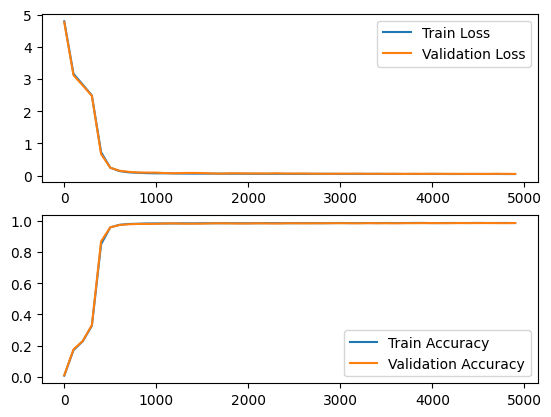

In [5]:
runner.plot_metrics()

## Step 6: Generating New Text
**What's happening here:** The exciting part - we're using our trained model to create new Shakespeare-style text!

We start with a prompt (like "OMELETTE\n To fry, or not to fry?") and feed it through our trained model. The model:
1. Takes our input and converts it to numerical format
2. Uses its learned patterns to predict the next character
3. Adds that character to the input and repeats
4. Continues this process for 500 new characters

The result should have some structure - while it might not be readable in english, it should capture some of the core statistical elements (e.g. ending phrases in punctuation, writing across multiple lines, etc.).

In [6]:
string_input = "\nOMELETTE.\nTo fry, or not to fry?"
predict = runner.generate(string_input, encode, decode, max_new_tokens = 500)
print("\033[94mInput:\033[0m \033[94m" + string_input + "\033[0m")
print("\033[92mOutput:\033[0m ", predict)

Input: 
OMELETTE.
To fry, or not to fry?
Output:  
Thet siesidy this  Hou suor shel’de she wer shee tat a t wecand we t t l ce blt p’tutt m se t s d a se c, ; d t I ccle pre wimy bieve p w
it nt thoooury uelith.
Coaneru,
Bu’d, I
I  she met I it hilk ghed any s paile ary i lle p_ is  o s m. he  
At foun tc thind thin
She, lordedy d terid Land thomshin yTon Ind [_mee owe wit, lif mee Lo otcre! ghat Wald, ak’d ts wn h.
shond chfo thirt at mre y. it t n trer tise d s,
O, hino t int tho thean?

CO rere t bomer aiteve gif thad u,is my heshe heontough
